In this notebook, we will look at two parts, clustering and recommender system.

In the first part, we will go through `KMeans` and `DBSCAN` algorithm to cluster `Starbucks` location geographically. We will use `scikit-learn` for implementation and `matplotlib` for visualisation.

In the second part, we will consider recommender systems with decomposition

In [8]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Clustering

First, let's look at the data for clustering

In [12]:
# Read csv with pandas, index indicates whether the first column is an index
data = pd.read_csv("data/starbucks_locations.csv", index_col=0)
data = data.dropna()

print(data.head())

              Longitude  Latitude
Store Number                     
47370-257954       1.53     42.51
22331-212325      55.47     25.42
47089-256771      55.47     25.39
22126-218024      54.38     24.48
17127-178586      54.54     24.51


In [13]:
# Reduce data for computability. just keep first 200
# data = data[:200]

# or reduce data to just some part of the planet
new_data = data[(data["Longitude"].between(49, 51)) & (data["Latitude"].between(26, 27))]

new_data

,Longitude,Latitude
Store Number,,
47088-256773,50.52,26.21
21603-213405,50.59,26.23
17255-179926,50.60,26.20
17189-179925,50.58,26.22
15439-161444,50.57,26.21
47377-258065,50.55,26.22
26955-246149,50.59,26.23
21148-209545,50.60,26.22
34324-95973,50.61,26.21


Now we can use `scikit-learn` to implement both `k-means` and `DBSCAN`. 

## K-means

In [23]:
# K-means with 10 neighbours and 500 iterations
kmeans = KMeans(10, max_iter=500)

print('Start K-means: ')
kmeans.fit(data)
print("Cluster centroids: " +str(kmeans.cluster_centers_))

Start K-means: 
Cluster centroids: [[-118.94318621   35.06546096]
 [ 117.82262271   28.26727676]
 [   2.17399302   50.9080617 ]
 [ -79.7761435    38.6651435 ]
 [ -62.85792176  -25.41293399]
 [  41.86422787   34.42387947]
 [ 132.87131984   36.33148702]
 [ -97.62492844   33.24260112]
 [-121.038315     48.389315  ]
 [ 106.16362035    2.25526419]]


To visualise the results, we need to write a plot function:

In [16]:
def graphClusters(all_data, labels, centers):
    # open a color map (cmap) which is a collection of colors which you can fetch by index (i.e. an integer)
    cmap = cm.get_cmap(name='tab10')
    
    # add the color as a new column in the dataframe and add the cluster labels
    all_data['color'] = labels
    
    # add the centroids (in case of K-means) to the plot by adding their coordinates  
    # example pyplot use: plt.plot(x, y, 'bo', linestyle='dashed')
    # example pyplot use: plt.plot(x, y,  color='blue', marker='o', linestyle='dashed')
    # more here: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html
    
    which_centroid = 0
    if centers:
        for center in centers:     
            plt.plot(center[0],center[1],'ro',label='centroid_'+str(which_centroid),
                     markersize=10,color=cmap(which_centroid))
            which_centroid += 1
    
    # add all the data points and use their label number to fetch a certain color
    # index is    
    for ind,row in all_data.iterrows():
        plt.plot(row['Longitude'],row['Latitude'],'ro',color=cmap(int(row['color'])+1),markersize=2)
        
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

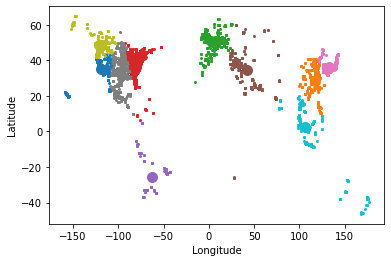

In [24]:
# The visulisation requires a long time, please be patient. Or you can try new_data or any other subset of original dataset
graphClusters(data,kmeans.labels_,list(kmeans.cluster_centers_))

## Open questions: why is it 10 clusters? How about less or more? Why iteration = 500? Is it possible to have less iterations?

The best tutorial of a Python library is always the official documentation, for example, `K-means`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

## DBSCAN

In [14]:
dbscan = DBSCAN(eps=10,min_samples=80)

print('Start DBSCAN: ')
dbscan.fit(data)
print("Labels: "+str(set(dbscan.labels_)))

Start DBSCAN: 
Labels: {0, 1, 2, 3, 4, 5, 6, -1}


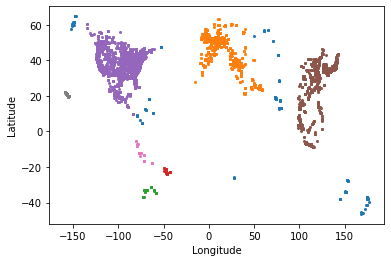

In [17]:
# The visulisation requires a long time, please be patient. Or you can try new_data or any other subset of original dataset
graphClusters(data,dbscan.labels_,[])
# the blue points are alll outliers

In [19]:
cmap = cm.get_cmap(name='tab10')
cmap

In [20]:
cmap

## Open questions: Can you try other eps and min_sample to improve the results of clustering?

The best tutorial of a Python library is always the official documentation, for example, `DBSCAN`: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

# Recommender system with decomposition

We can also consider decomposition. 
We convert the utility matrix $M (r \times m)$ into $M' = UV^T \approx M$  with $U (r \times l)$ and $V^T (l \times m)$.

In [1]:
from sklearn.decomposition import NMF

loading the dataset

In [4]:
# load data
ratings = pd.read_csv('data/ratings.csv')

# sample dataset
# be careful, once again a very heavy operation
ratings = ratings[:1000]

print(ratings.head())

# print some information
noMovies = len(ratings['movieId'].unique())
noUsers = len(ratings['userId'].unique())
print(str(noMovies)+" from "+str(noUsers)+' users')

   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580
698 from 11 users


Do some pre-processing before we carefully look at it.

In [5]:
# create empty utility matrix
utility = np.zeros(shape=(noUsers,noMovies))

# store movieIds as indices to use in utility matrix
movieIds = {}
midi = 0
for value in ratings['movieId'].unique():
    movieIds[value]=midi
    midi = midi + 1

# populate utility matrix
for index, line in ratings.iterrows():
    uid = int(line['userId'])-1
    mid = movieIds[line['movieId']]
    rating = line['rating']
    utility[uid,mid]=rating

Now let's do the matrix factorisation with `scikit-learn`:

In [39]:
decomposition = NMF(n_components=50, init='random', random_state=0, max_iter=500)
U = decomposition.fit_transform(utility)
V_T = decomposition.components_

In [40]:
print('Shape of U (#reviewers x #latent factors): ', np.shape(U))
print('Shape of V_T (#latent factors x #movies): ', np.shape(V_T))

Shape of U (#reviewers x #latent factors):  (11, 50)
Shape of V_T (#latent factors x #movies):  (50, 698)


Now we can calculate $M'$:

In [41]:
M_ = np.dot(U, V_T)
print(np.shape(M_))

(11, 698)


We can see how more dimensions provide a closer approximation of the original matrix:

In [6]:
for n_comp in range(20,201,10):
    decomposition = NMF(n_components=n_comp, init='random', random_state=1, max_iter=1500)
    U = decomposition.fit_transform(utility)
    V_T = decomposition.components_
    M_ = np.dot(U, V_T)
    
    # calculate difference between both matrices
    diff = utility-M_
    print(f"for {n_comp} components,\tdifference was {np.sum(diff)}")
    
print("Completed!") # this will run for a while, up to a minute or two.


for 20 components,	difference was -1.4564411801349022
for 30 components,	difference was -2.2441172915608996
for 40 components,	difference was -2.045007344128223
for 50 components,	difference was -1.7393667182630768
for 60 components,	difference was -2.3652180942300567
for 70 components,	difference was -1.4157237250771226
for 80 components,	difference was -1.5217231805824507
for 90 components,	difference was -1.657744614155655
for 100 components,	difference was -2.513517973190455


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


for 110 components,	difference was -0.0012198791946101883


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


for 120 components,	difference was -0.00029329357377434425
for 130 components,	difference was -1.5444670034928814
for 140 components,	difference was -1.2188398456560754


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


for 150 components,	difference was -0.0004657428447350433


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


for 160 components,	difference was -0.0002074151734390988
for 170 components,	difference was -3.0449593084660465


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


for 180 components,	difference was -3.2178170483269796e-06


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


for 190 components,	difference was -6.2471026429613256e-06
for 200 components,	difference was -0.0003716953137671367
Completed!


C:\Users\zchen112\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


more reading here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

What do you see? is the difference between matrixes getting larger or smaller? is that good?

## Open Questions: Can you store all `diff` and plot a figure, the number of components vs diff, and observe the pattern?